# MAE Latent Space Visualization (PCA / UMAP / t-SNE)

This notebook loads the pretrained MAE encoder, computes latent vectors `z` for each brine sample, and visualizes them using:

- PCA (always available via scikit-learn)
- t-SNE (always available via scikit-learn)
- UMAP (optional, requires `umap-learn`)

Coloring (if metadata columns exist in `data/processed/brines.csv`):
- `Type_of_water`
- `Brine`
- `Location`
- or none


In [9]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

try:
    import umap  # type: ignore
except Exception:
    umap = None

from src.models.inference import auto_device
from src.models.mae import TabularMAE, TabularMAEConfig

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MAE_CKPT = PROJECT_ROOT / "models" / "mae_pretrained.pth"


DEVICE = auto_device()
DEVICE

device(type='mps')

In [10]:
x_lake_path = PROCESSED_DIR / "X_lake.npy"
brines_csv_path = PROCESSED_DIR / "brines.csv"

assert x_lake_path.exists(), f"Missing: {x_lake_path}" 
assert brines_csv_path.exists(), f"Missing: {brines_csv_path}"

X = np.load(x_lake_path)
meta = pd.read_csv(brines_csv_path)

print("X:", X.shape, X.dtype)
print("meta:", meta.shape)

# Expect X and brines.csv to have the same row order.
if len(meta) != X.shape[0]:
    n = min(len(meta), X.shape[0])
    print(f"WARNING: row mismatch meta={len(meta)} vs X={X.shape[0]} -> truncating to {n}")
    meta = meta.iloc[:n].reset_index(drop=True)
    X = X[:n]

meta.head()

X: (946, 10) float32
meta: (946, 15)


,Li_gL,Mg_gL,Na_gL,K_gL,Ca_gL,SO4_gL,Cl_gL,MLR,TDS_gL,Type_of_water,Brine,Location,Latitude,Longitude,Light_kW_m2
0,0.0180,33.310,19.225,7.010,12.330,0.61,NaN,1850.555556,225.8200,Salt lake brine,Dead Sea (Dea.),Israel,31.5,34.8,0.235208
1,0.0200,52.000,33.000,8.000,18.600,0.35,224.00,2600.000000,NaN,Salt lake brine,Dead Sea (Dea.),Israel,31.5,34.8,0.235208
2,0.0120,30.900,30.100,5.600,12.900,0.61,161.00,2575.000000,NaN,Salt lake brine,Dead Sea (Dea.),Israel,31.5,34.8,0.235208
3,0.0467,65.194,1.696,1.356,24.614,NaN,233.94,1396.017131,326.8467,Salt lake brine,Dead Sea (Dea.),Jordan,31.2,36.3,0.251708
4,0.2200,17.100,53.700,NaN,26.300,0.12,152.00,77.727273,249.4400,Salt lake brine,Salton See,USA,39.8,-98.6,0.188042


In [11]:
assert MAE_CKPT.exists(), f"Missing checkpoint: {MAE_CKPT}. Train first via src/models/train_mae.py"

ckpt = torch.load(MAE_CKPT, map_location="cpu")
cfg = TabularMAEConfig(**ckpt.get("mae_config", {}))
num_features = int(ckpt["num_features"])

model = TabularMAE(num_features=num_features, config=cfg)
model.load_state_dict(ckpt["model_state_dict"])
model.eval().to(DEVICE)

print("Loaded MAE:", cfg)
print("num_features:", num_features)

assert X.shape[1] == num_features, f"X has {X.shape[1]} features, model expects {num_features}"

Loaded MAE: TabularMAEConfig(d_model=256, n_heads=16, n_layers=4, mlp_ratio=2.0, dropout=0.1, mask_ratio=0.1)
num_features: 10


/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [12]:
def encode_latents(model: TabularMAE, X: np.ndarray, *, batch_size: int = 256) -> np.ndarray:
    Z = []
    xt = torch.from_numpy(X).to(dtype=torch.float32)
    for start in range(0, xt.shape[0], batch_size):
        batch = xt[start : start + batch_size].to(DEVICE)
        with torch.no_grad():
            z = model.encode(batch)
        Z.append(z.detach().cpu().numpy())
    return np.concatenate(Z, axis=0)


Z = encode_latents(model, X, batch_size=256)
print("Z:", Z.shape, Z.dtype)
Z[:2, :8]

Z: (946, 256) float32


array([[-1.0447342 , -0.9783538 ,  0.8155464 ,  1.5870314 ,  2.107704  ,
         0.34569043, -0.05754876, -0.8908861 ],
       [-1.9025335 , -0.16378239,  0.4441378 ,  1.2456318 ,  2.123655  ,
         0.31144837, -0.77263594, -0.94772875]], dtype=float32)

In [13]:
def plot_embedding(emb2: np.ndarray, *, title: str, color: str | None = None, df: pd.DataFrame | None = None):
    plt.figure(figsize=(7, 6))

    if color is None or df is None or color not in df.columns:
        plt.scatter(emb2[:, 0], emb2[:, 1], s=10, alpha=0.7)
        plt.title(title)
        plt.xlabel("dim-1")
        plt.ylabel("dim-2")
        plt.tight_layout()
        return

    series = df[color].astype("string").fillna("<NA>")
    categories = series.unique().tolist()
    categories = sorted(categories)

    # If there are too many categories, fall back to no legend.
    show_legend = len(categories) <= 25

    cmap = plt.get_cmap("tab20")
    color_map = {c: cmap(i % 20) for i, c in enumerate(categories)}

    for c in categories:
        idx = (series == c).to_numpy()
        plt.scatter(emb2[idx, 0], emb2[idx, 1], s=10, alpha=0.7, label=str(c), color=color_map[c])

    plt.title(f"{title} (color={color})")
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    if show_legend:
        plt.legend(markerscale=2, fontsize=8, loc="best")
    plt.tight_layout()


color_candidates = [None, "Type_of_water", "Brine", "Location"]
available_colors = [c for c in color_candidates if c is None or c in meta.columns]
available_colors

[None, 'Type_of_water', 'Brine', 'Location']

/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Use

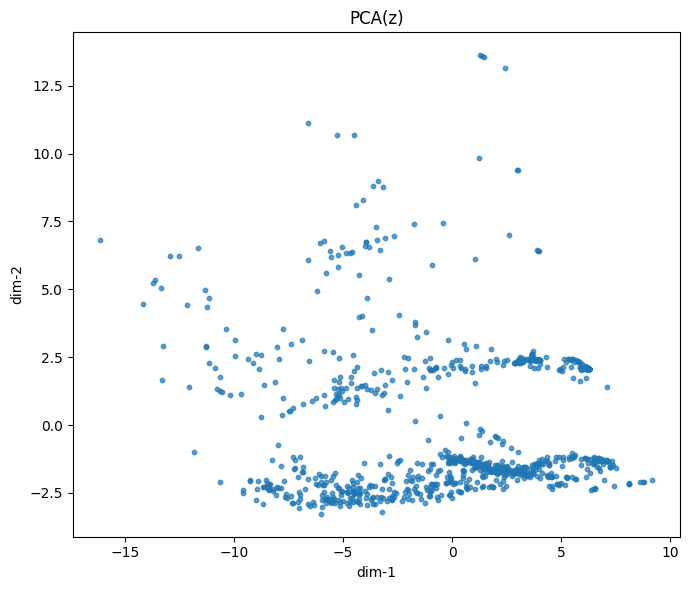

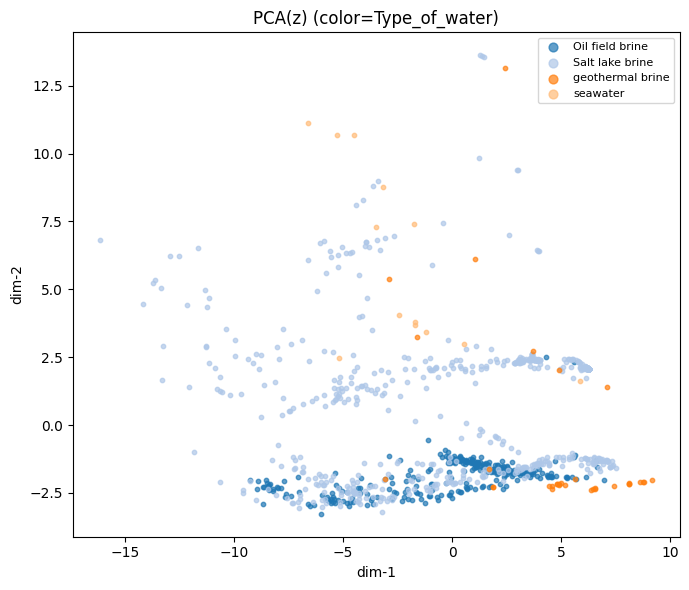

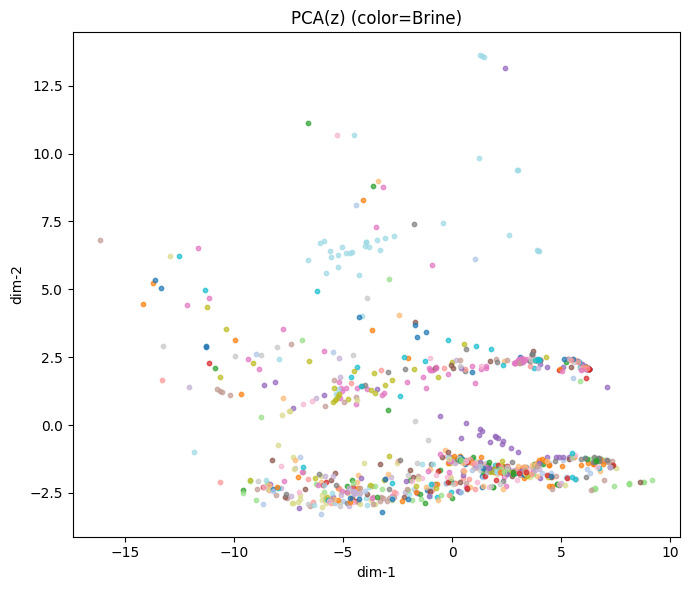

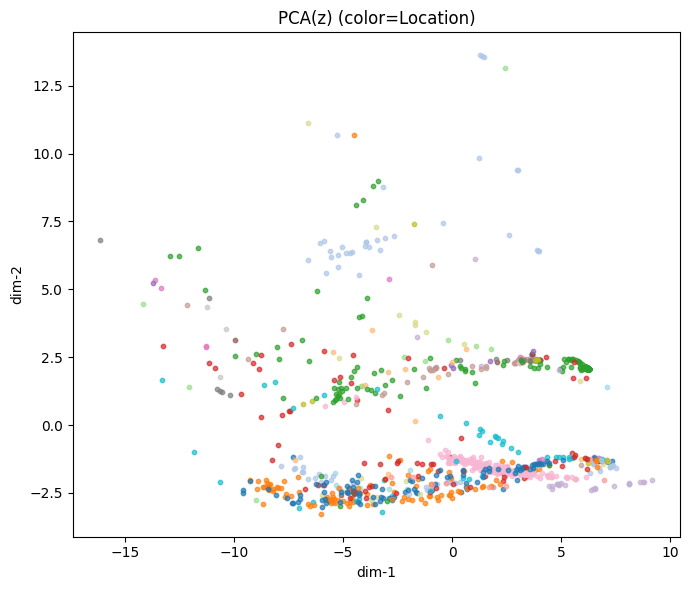

In [14]:
# PCA
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z)

for c in available_colors:
    plot_embedding(Z_pca, title="PCA(z)", color=c, df=meta)
plt.show()

/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


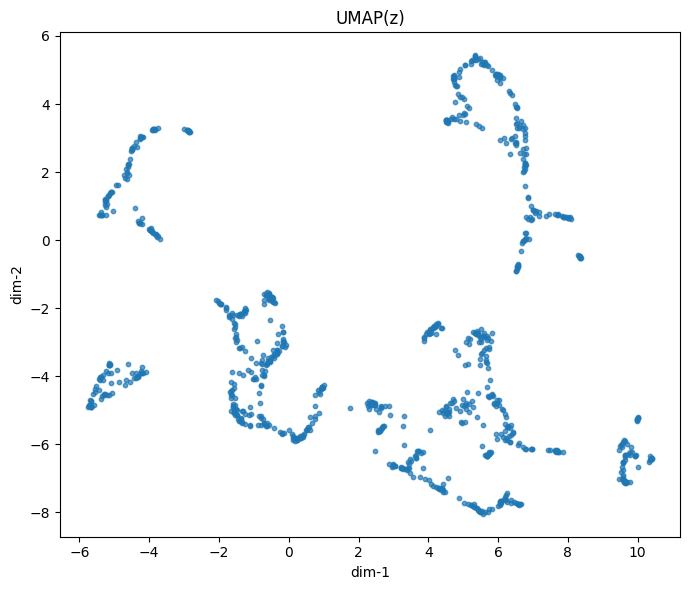

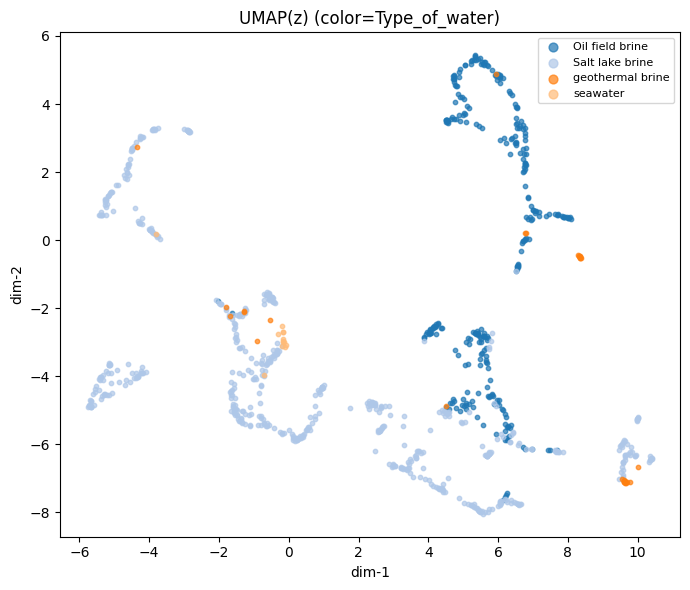

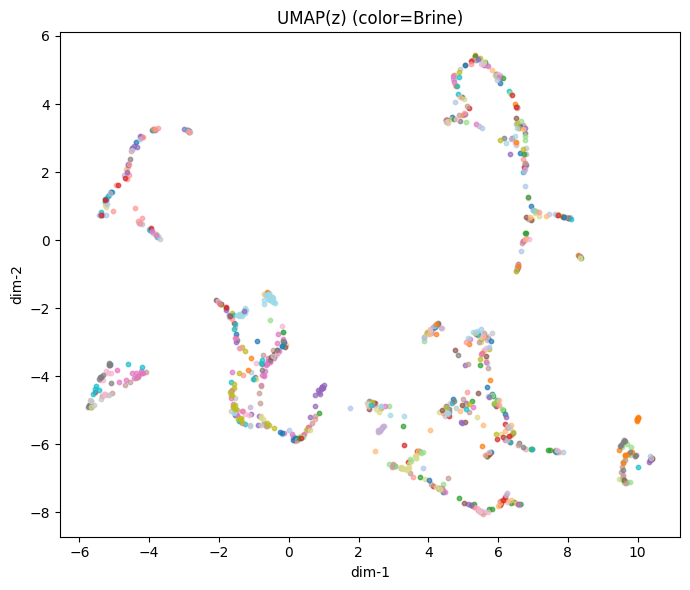

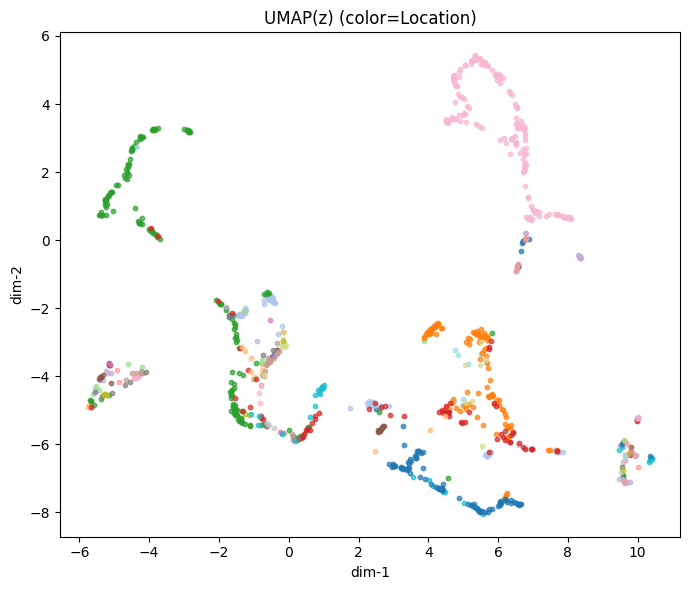

In [15]:
# UMAP (optional)
if umap is None:
    print("UMAP not available. Install with: pip install umap-learn")
else:
    reducer = umap.UMAP(n_components=2, random_state=42)
    Z_umap = reducer.fit_transform(Z)
    for c in available_colors:
        plot_embedding(Z_umap, title="UMAP(z)", color=c, df=meta)
    plt.show()

/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/jiahaozhang/miniconda3/envs/global-brine-lithium-model/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Use

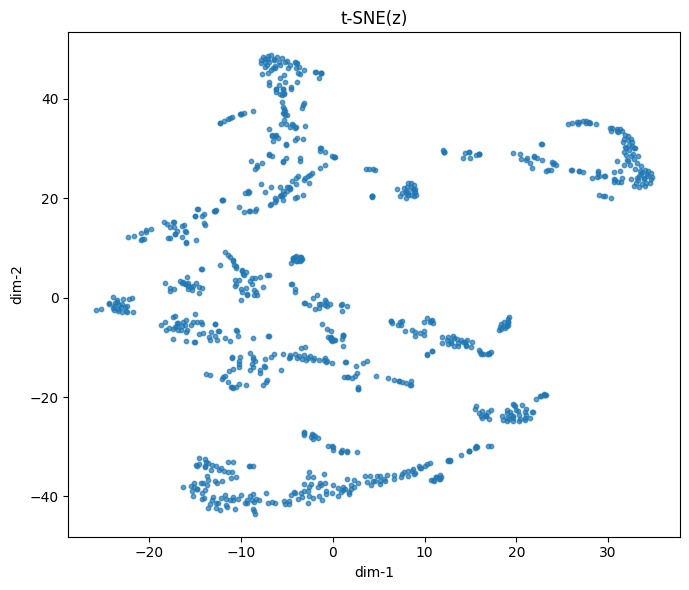

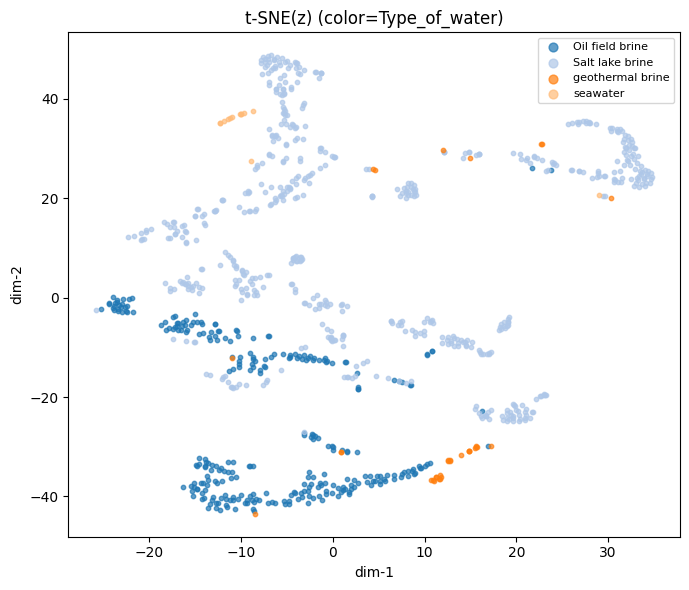

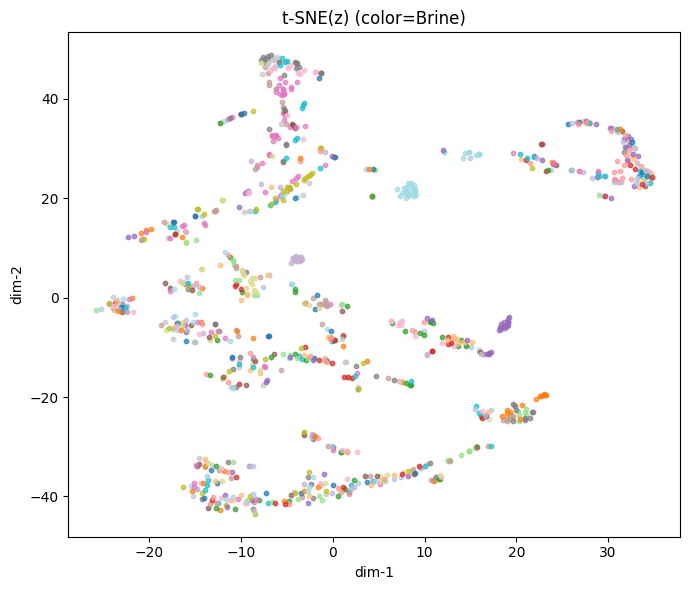

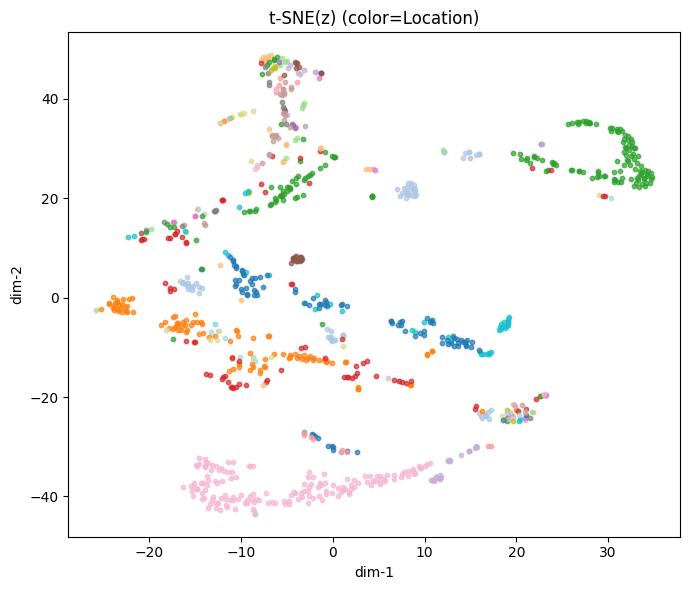

In [16]:
# t-SNE (can be slow on large datasets; adjust perplexity if needed)
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=42)
Z_tsne = tsne.fit_transform(Z)

for c in available_colors:
    plot_embedding(Z_tsne, title="t-SNE(z)", color=c, df=meta)
plt.show()